# Imports and Settings

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

import warnings

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 5)
warnings.filterwarnings('ignore')

# Preprocessing Pipeline and SMOTE 

In [3]:
df = pd.read_csv('data.csv').drop(columns='Loan_ID')
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
X = df[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area']]
y = df['Loan_Status']
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

In [5]:
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term']
cat_features = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Credit_History','Property_Area']

In [6]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
])

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [9]:
smote = SMOTE(sampling_strategy='minority')

X_sm, y_sm, = smote.fit_resample(X_train, y_train)

In [10]:
def plot_cfn(cnf_matrix):
    """
    takes an sklearn confusion matrix as an input and plots it using seaborn
    """
    class_names=['N','Y'] # name  of classes
    fig, ax = plt.subplots()

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix, columns=class_names, index=class_names), annot=True, cmap="YlGnBu" ,fmt='g' )
    ax.xaxis.set_label_position("top")


    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Modeling

## Logistic Regression

In [11]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
print(classification_report(y_test, lg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.45      0.60        33
           1       0.83      0.98      0.90        90

    accuracy                           0.84       123
   macro avg       0.86      0.72      0.75       123
weighted avg       0.84      0.84      0.82       123



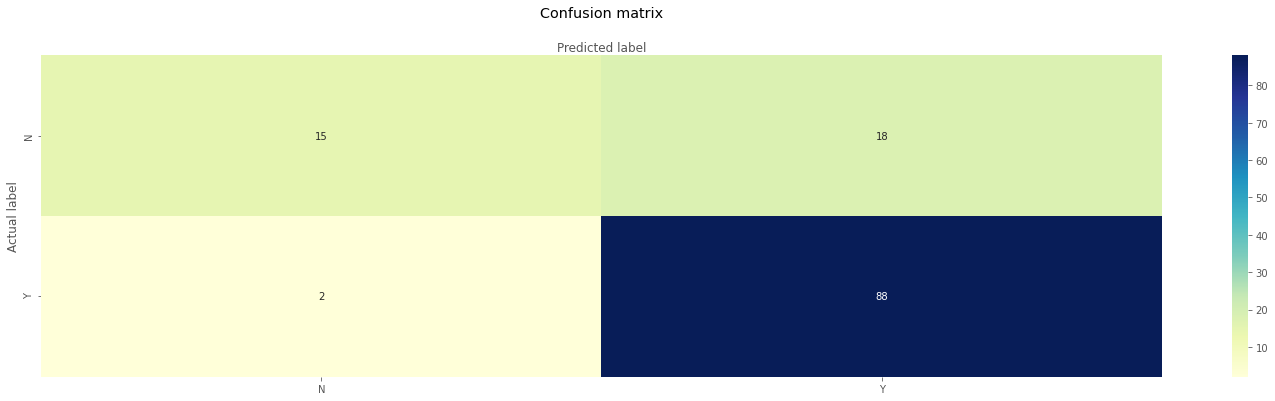

In [12]:
cnf_matrix = confusion_matrix(y_test, lg.predict(X_test))
plot_cfn(cnf_matrix)

Logistic regression has high accuracy but low recall. Very poor job at identifying rejected loans.

In [13]:
lg_smote = LogisticRegression()
lg_smote.fit(X_sm, y_sm)
print(classification_report(y_test, lg_smote.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        33
           1       0.83      0.91      0.87        90

    accuracy                           0.80       123
   macro avg       0.75      0.70      0.71       123
weighted avg       0.78      0.80      0.79       123



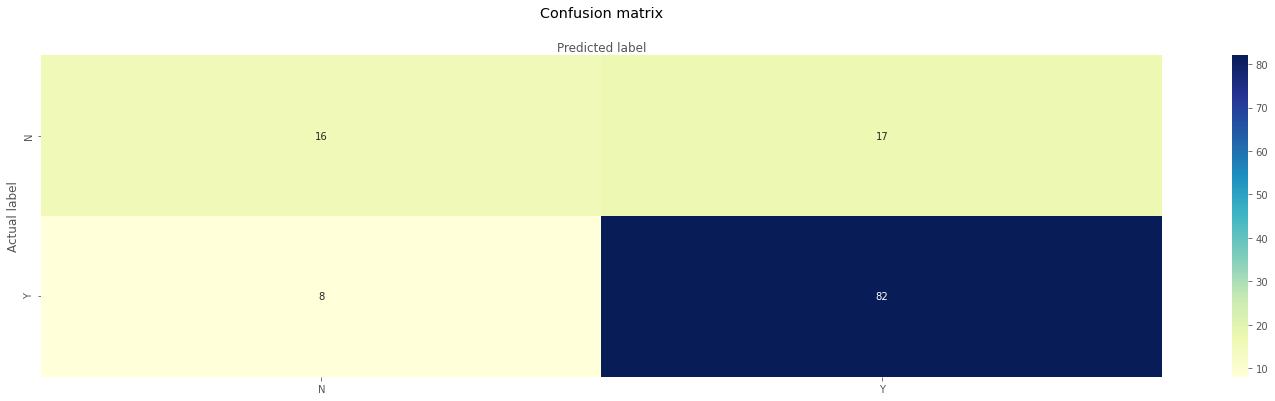

In [14]:
cnf_matrix = confusion_matrix(y_test, lg_smote.predict(X_test))
plot_cfn(cnf_matrix)

Logistic regression with SMOTE data has imroved at finding rejected loan status. Accuracy has been reduced. Performance still underwhelming.

## SVC

In [15]:
svc = svm.SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
print(classification_report(y_test,  svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.44      0.52      0.47        33
           1       0.81      0.76      0.78        90

    accuracy                           0.69       123
   macro avg       0.62      0.64      0.63       123
weighted avg       0.71      0.69      0.70       123



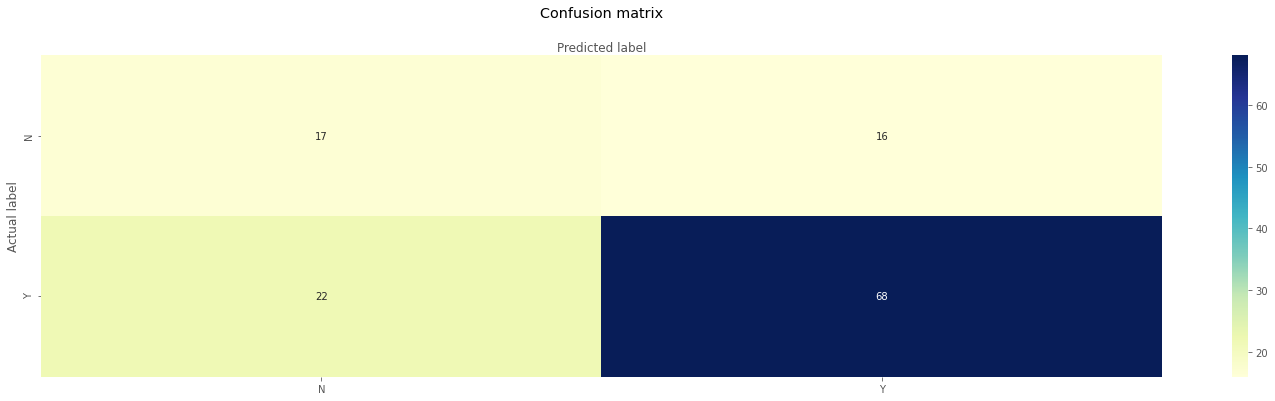

In [16]:
cnf_matrix = confusion_matrix(y_test,  svc.predict(X_test))
plot_cfn(cnf_matrix)

Support Vector Classifier is better at finding rejected loans that logistic regression. However the accuracy is noticably lower.

In [17]:
svm_smote = svm.SVC(kernel='sigmoid')
svm_smote.fit(X_sm, y_sm)
print(classification_report(y_test, svm_smote.predict(X_test)))

              precision    recall  f1-score   support

           0       0.35      0.61      0.44        33
           1       0.80      0.59      0.68        90

    accuracy                           0.59       123
   macro avg       0.58      0.60      0.56       123
weighted avg       0.68      0.59      0.62       123



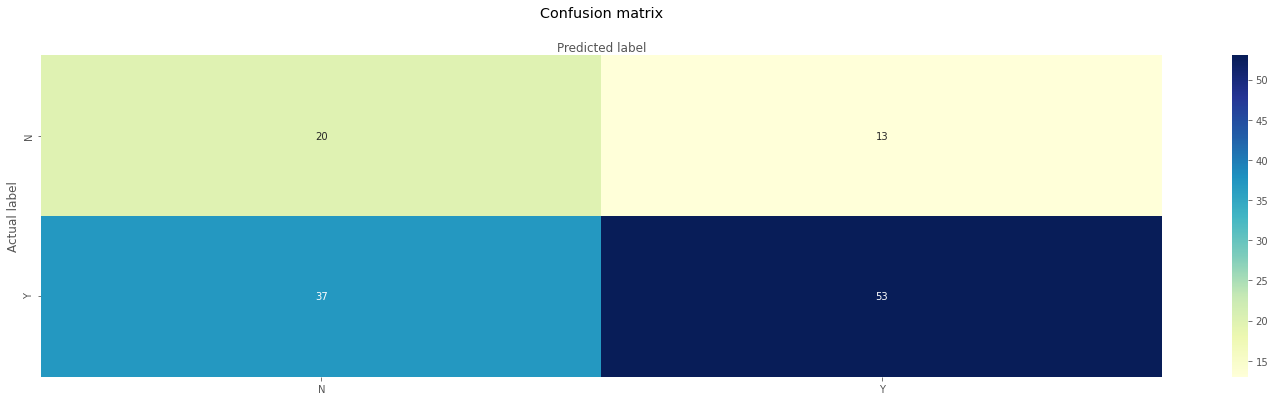

In [18]:
cnf_matrix = confusion_matrix(y_test, svm_smote.predict(X_test))
plot_cfn(cnf_matrix)

Support Vector Classifier has improved a lot at finding rejected loan status, has the highest recall so far. 

In [19]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale'],
              'kernel': ['sigmoid']} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose=0)
  
# fitting the model for grid search
grid.fit(X_sm, y_sm)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale'],
                         'kernel': ['sigmoid']})

In [20]:
grid.best_estimator_

SVC(C=1000, gamma=0.001, kernel='sigmoid')

In [21]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



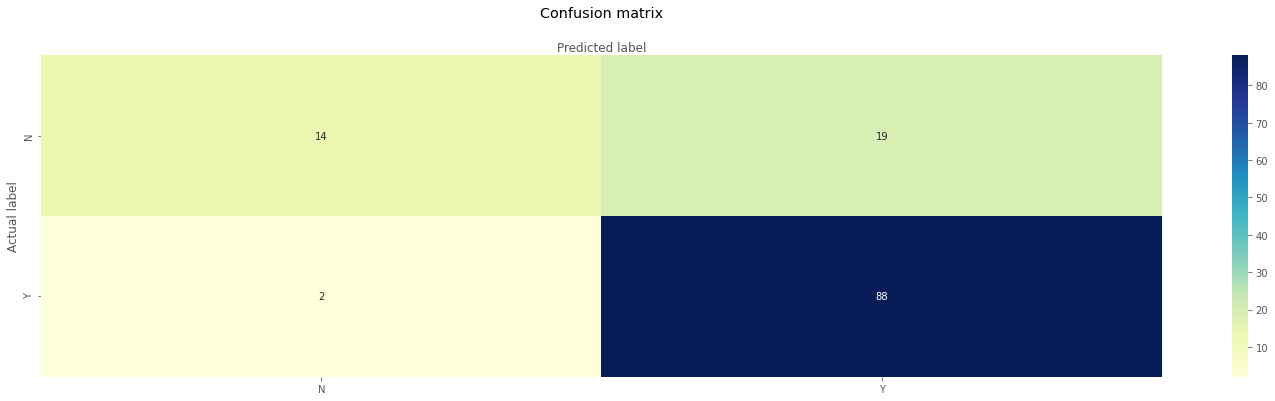

In [22]:
cnf_matrix = confusion_matrix(y_test, grid.predict(X_test))
plot_cfn(cnf_matrix)

## XGB

In [23]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
print(classification_report(y_test, xgbc.predict(X_test)))

[00:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.59      0.61      0.60        33
           1       0.85      0.84      0.85        90

    accuracy                           0.78       123
   macro avg       0.72      0.73      0.72       123
weighted avg       0.78      0.78      0.78       123



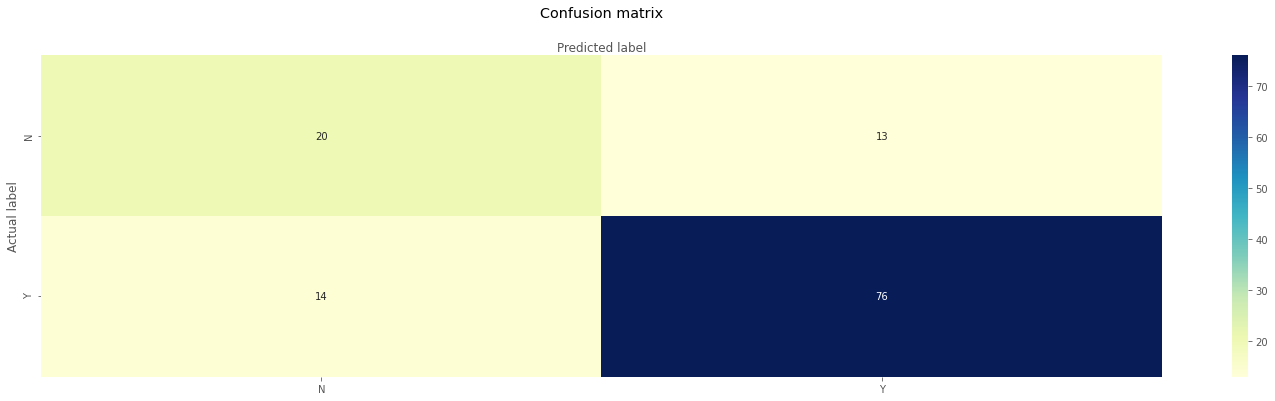

In [24]:
cnf_matrix = confusion_matrix(y_test, xgbc.predict(X_test))
plot_cfn(cnf_matrix)

XGBoost Classifier is the best performing model so far. It has the recall of Support Vector Classifier but also has high accuracy like the logisitic model.

In [25]:
xgbc_smote = xgb.XGBClassifier()
xgbc_smote.fit(X_sm, y_sm)
print(classification_report(y_test, xgbc_smote.predict(X_test)))

[00:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.54      0.61      0.57        33
           1       0.85      0.81      0.83        90

    accuracy                           0.76       123
   macro avg       0.69      0.71      0.70       123
weighted avg       0.77      0.76      0.76       123



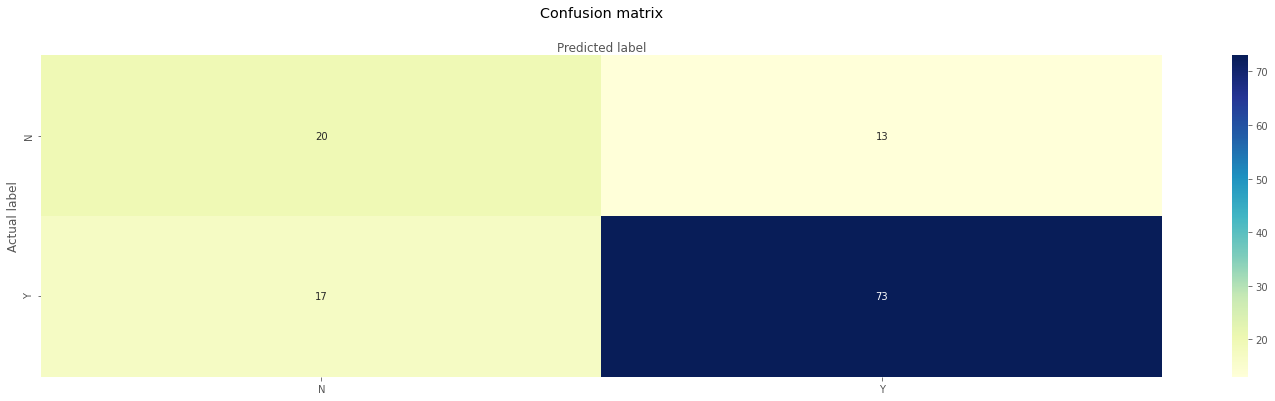

In [26]:
cnf_matrix = confusion_matrix(y_test, xgbc_smote.predict(X_test))
plot_cfn(cnf_matrix)

XGBoost Classifier improves when trained on the SMOTE data. Recall increases slightly at the cost of a slight decrease in accuracy. Since it is the best model so far, we will proceed with a hyper-parameter tuning for this model.


# Grid Search

In [27]:

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


xgb = xgb.XGBClassifier()        

grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, verbose=0)
grid.fit(X_sm, y_sm)

[00:57:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [28]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.64      0.58        33
           1       0.86      0.79      0.82        90

    accuracy                           0.75       123
   macro avg       0.69      0.71      0.70       123
weighted avg       0.77      0.75      0.75       123



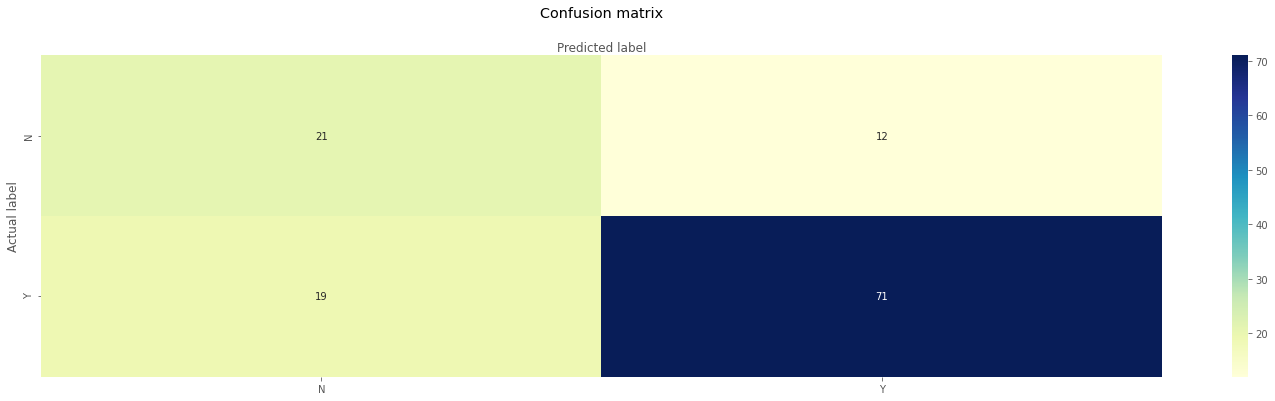

In [29]:
cnf_matrix = confusion_matrix(y_test, grid.predict(X_test))
plot_cfn(cnf_matrix)

After tuning, the XGBoost model now has the highest recall and accuracy combination. Depite all the tuning the recall (around 0.61) and accuracy (around 0.73) are still not as high as I'd want them to be. However, after considering the dataset is quite small, these scores may be permissable. Now on to model persistence.

# Model Persistence
Now that the best model has been found:
- Save the model and preprocessor using the pickle library so that they can be reused in the other python scripts

In [40]:
import pickle
pickle.dump( grid.best_estimator_, open( "model.p", "wb" ) )
pickle.dump( preprocessor, open( "preprocess.p", "wb" ) )

# App request from Notebook

- Model has been saved (above) and has been implimented in the python scripts. 
- Run the python script from the terminal and then follow along to ask the app to return a prediction to the Notebook.

In [96]:
json_data = {'Gender': 'Male', 
            'Married': 'No', 
            'Dependents': 0,
            'Education': 'Graduate', 
            'Self_Employed': 'Yes',
            'ApplicantIncome': 7085,
            'CoapplicantIncome': 0.0,
            'LoanAmount': 84.0,
            'Loan_Amount_Term': 360.0,
            'Credit_History': 0, 
            'Property_Area': 'Semiurban'}

In [97]:
import requests
URL = "http://127.0.0.1:5000/Prediction"
# sending get request and saving the response as response object 
r = requests.post(url = URL, json = json_data)

In [98]:
print(r.json())

You are probably not eligible for a loan


# GUI App
- Making requests in the notebook is fine for testing uses.
- However, a GUI app would be more intuitive and valueable either for bank workers or for customers.
- run the python script in the terminal to enjoy a flask app that uses the model to give a prediction on if a customer will be approved for a loan.